# Notebook for training self-driving models

### Set Constants to configure network:

In [40]:
LOCAL = True
if LOCAL:
  assets_path = '/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/'
else:
  assets_path = '/content/drive/MyDrive/enph353/enph353_competition/assets/'

# Training directories
IMAGE_PATHS = [assets_path + 'images/outer_lap/optimize/default2000',
               assets_path + 'images/outer_lap/optimize/dagger']

# Model output directory
modelpath = assets_path + 'models/outer_lap/5convlayers/optimize/dagger4' # path to save model to 
EPOCHS = 10
IS_GRAY = True

### install libraries

In [41]:
if not LOCAL:
  !pip install -q tensorflow==2.9.3
import tensorflow as tf
print(tf.__version__)
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
print()

2.9.3



In [42]:
import os
for path, dirs, files in os.walk(assets_path):
  print (path)
  for d in dirs:
    print(d)

/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/
images
models
/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images
outer_lap
/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images/outer_lap
default10000
dagger
optimize
slight_recenter
/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images/outer_lap/default10000
/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images/outer_lap/dagger
/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images/outer_lap/optimize
default2000
dagger
/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images/outer_lap/optimize/default2000
/home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images/outer_lap/optimize

### mount drive

In [43]:
if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')

# Part 1: Load in data and labels

## 1.1: Load in images

In [44]:
images = []
for path in IMAGE_PATHS:
  for im in os.listdir(path)[:5]:
    images.append(path + '/' + im)
images
print('training on', sum([len(os.listdir(p)) for p in IMAGE_PATHS]), 'images.')

training on 4255 images.


## 1.2: Generate labels

In [45]:
def get_action_from_filename(filename):
  vels = [float(v) for v in filename.split(']')[0].split('[')[1].split(',')]
  if vels[1] == 0:
    return 0 # forward
  elif vels[1] > 0:
    return 1
  else:
    return 2

print("example image and label:")
for im in images[:1]:
  print('X:', im, '\nY:', get_action_from_filename(im))

example image and label:
X: /home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/images/outer_lap/optimize/default2000/[0.36450000000000005, 1.2100000000000002]2023-03-25 07:55:02.032892.png 
Y: 1


## 1.3: Organize images and labels into X and Y tensors

In [46]:
X = []
Y = []
for path in IMAGE_PATHS:
  for image in os.listdir(path):
    cv_image = cv2.imread(path + '/' + image)
    if IS_GRAY:
      cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
    X.append(cv_image)
    Y.append(tf.one_hot(get_action_from_filename(image), 3))

X = np.array(X)
Y = np.array(Y)
indices = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
idx = tf.random.shuffle(indices)
X = tf.gather(X, idx)
Y = tf.gather(Y, idx)

'X shape:', X.shape, 'Y_shape:', Y.shape

('X shape:', TensorShape([4255, 36, 64]), 'Y_shape:', TensorShape([4255, 3]))

## 1.4 Split data into training and validation splits

In [47]:
train_split = 0.9
N = int(X.shape[0] * train_split)
X_train = X[:N]
Y_train = Y[:N]
X_valid = X[N:]
Y_valid = Y[N:]
'X_train:', X_train.shape, 'X_valid: ', X_valid.shape

('X_train:',
 TensorShape([3829, 36, 64]),
 'X_valid: ',
 TensorShape([426, 36, 64]))

### Test random image and its label

Text(0.5, 1.0, 'Random example... Label: tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)')

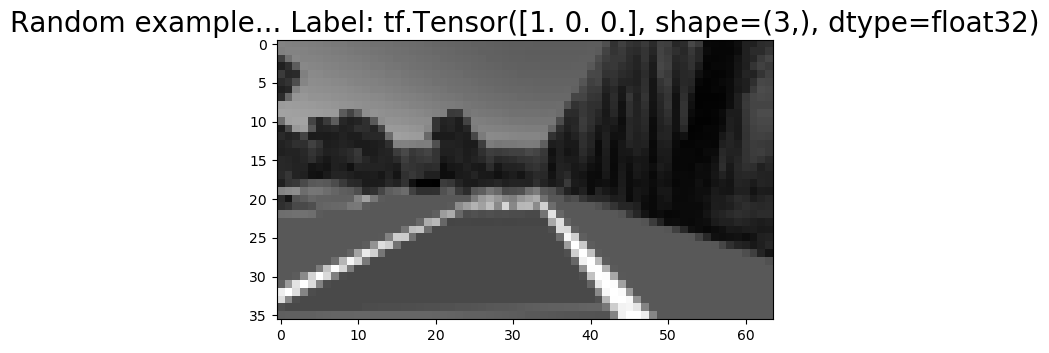

In [48]:
N = 1 # Rerun for more random images
idx = np.random.randint(0, X.shape[0]) # sample from X
plt.imshow(X[idx], cmap='gray')
plt.title('Random example... Label: ' + str(Y[idx]), size=20)

# Part 2: Train Model

In [49]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(24, (3,3), strides=(2,2), activation='relu', input_shape=(36, 64, 1)))
model.add(layers.Conv2D(36, (3,3), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(48, (3,3), strides=(1,1), activation='relu'))
model.add(layers.Conv2D(64, (2,2), strides=(1,1), activation='relu'))
model.add(layers.Conv2D(64, (2,2), strides=(1,1), activation='relu'))
model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3)) # output layer
model.add(layers.Softmax())
print("Model Summary:")
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
print('\n\n\n--------------------')
print("Train Model:")
history = model.fit(X_train, Y_train, batch_size=32, epochs=EPOCHS, 
                    validation_data=(X_valid, Y_valid))

Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 17, 31, 24)        240       
                                                                 
 conv2d_16 (Conv2D)          (None, 8, 15, 36)         7812      
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 13, 48)         15600     
                                                                 
 conv2d_18 (Conv2D)          (None, 5, 12, 64)         12352     
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 11, 64)         16448     
                                                                 
 flatten_3 (Flatten)         (None, 2816)              0         
                                                                 
 dense_12 (Dense)            (None, 128

14/14 - 0s - loss: 0.4042 - accuracy: 0.8075 - 51ms/epoch - 4ms/step


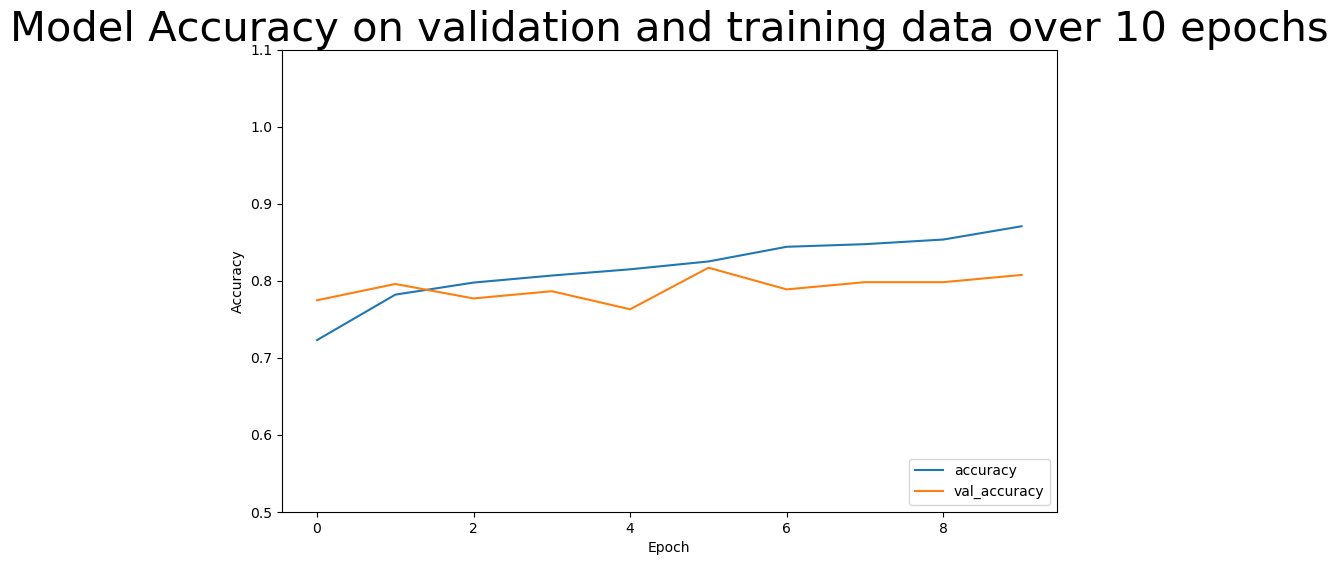

In [50]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')
plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)


test_loss, test_acc = model.evaluate(X_valid,  Y_valid, verbose=2)

## 2.2 Visualize softmax outputs

1/1 [==============================] - 0s 11ms/step


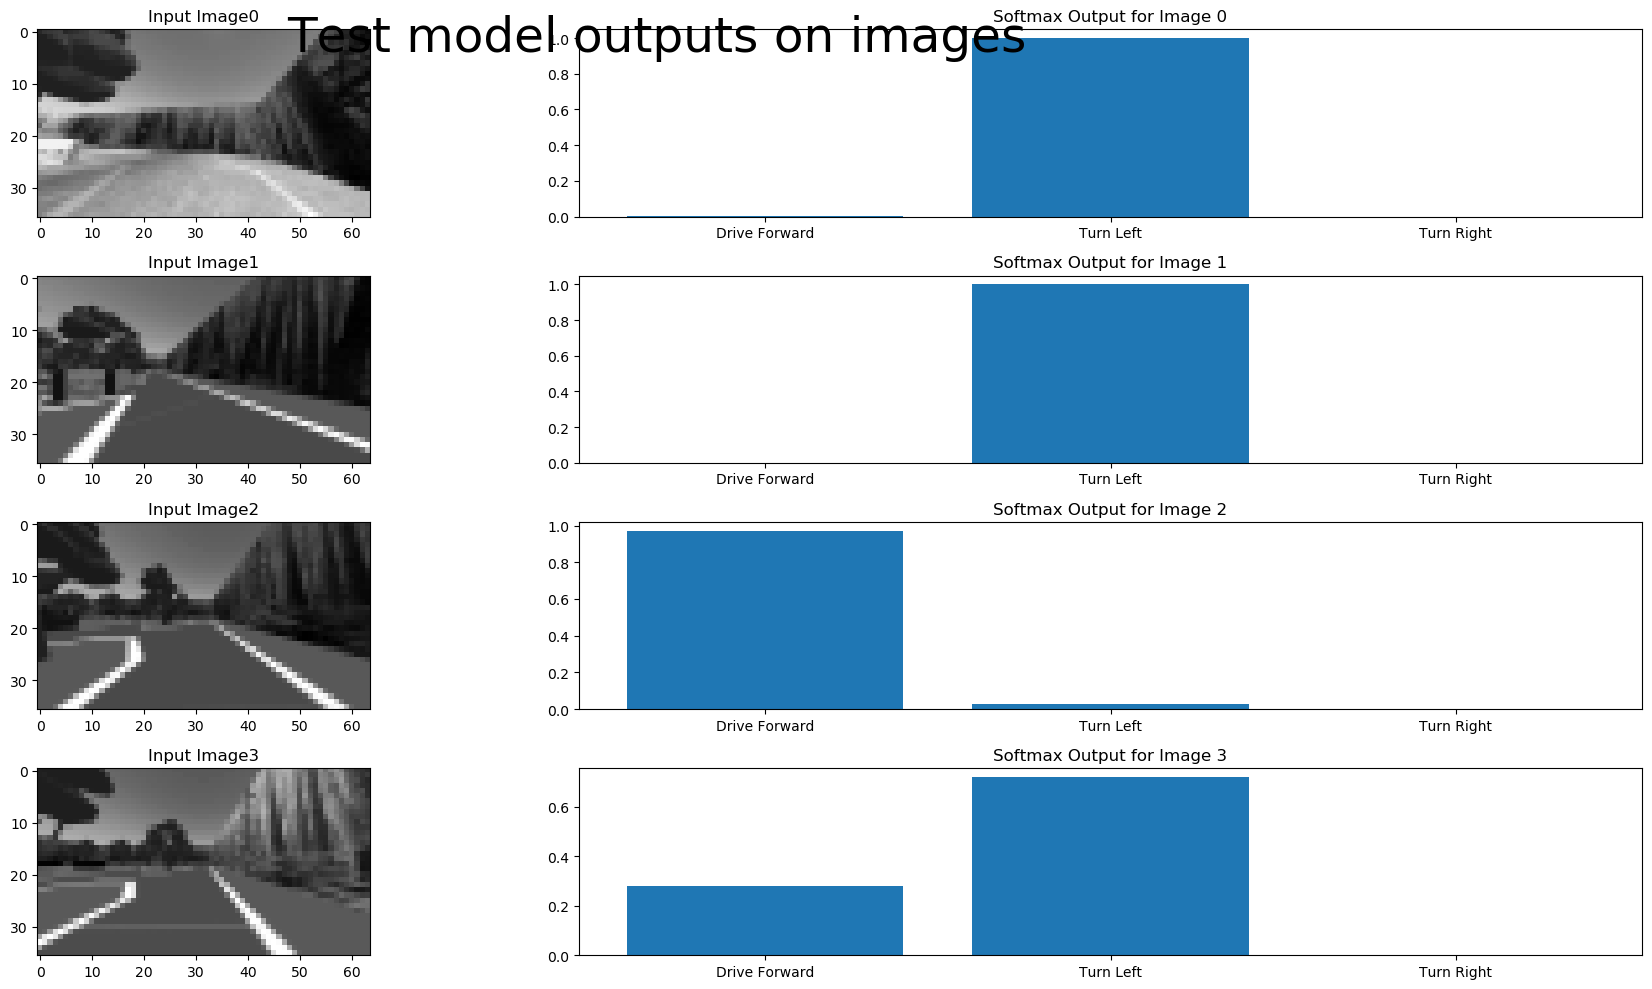

In [51]:
N = 4
fig, axs = plt.subplots(N, 2, figsize=(20,10))
fig.suptitle('Test model outputs on images', size=35)
for i in range(N):
  idx = np.random.randint(0, X_valid.shape[0])
  ypred = model.predict(tf.expand_dims(X_valid[idx], 0))
  axs[i,0].imshow(X_valid[idx], cmap='gray')
  axs[i,1].bar(['Drive Forward', 'Turn Left', 'Turn Right'], ypred.tolist()[0])
  axs[i,0].set_title('Input Image' + str(i))
  axs[i,1].set_title('Softmax Output for Image '+ str(i))
fig.tight_layout()

In [52]:
model.save(modelpath)

INFO:tensorflow:Assets written to: /home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/models/outer_lap/5convlayers/optimize/dagger4/assets


INFO:tensorflow:Assets written to: /home/fizzer/Insync/1mackenziekyle@gmail.com/Google Drive/enph353/enph353_competition/assets/models/outer_lap/5convlayers/optimize/dagger4/assets
